# Identify Fraud from Enron Email

[Cédric Campguilhem](https://github.com/ccampguilhem/Udacity-DataAnalyst), November 2017

<a id="Top">

## Table of contents

- [Introduction](#Introduction)
- [Project organisation](#Organisation)
- [Dataset](#Dataset)
    - [Downloading dataset](#Download)
    - [Data exploration](#Exploration)
    - [Dataset questions](#Dataset questions)
- [Feature selection](#Feature)
    - [Combine email and financial features](#Combine)
    - [Univariate feature selection](#Univariate)
    - [Recursive feature selection](#Recursive)
    - [Conclusion](#Feature selection conclusion)
- [Machine learning](#Machine learning)
    - [Cross-validation strategy](#Cross-validation strategy)
    - [Algorithm choice](#Algorithm choice)
    - [Bias variance trade-off](#Bias variance trade-off)
    - [Time to learn !](#Learn)
    - [Compare algorithms](#Compare algorithms)
    - [Conclusion](#Learning conclusion)
- [Conclusion](#Conclusion)
- [Pro tips](#Pro Tips)
- [Appendix](#Appendix)

<a id='Introduction'/>

## Introduction [*top*](#Top)

This project is related to Introduction to Machine Learning course for Udacity Data Analyst Nanodegree program. The purpose of this project is to analyse Enron email dataset and setup a machine learning algorithm to identify persons of interest involved in massive fraud causing Enron bankruptcy in 2002.

The list of persons of interest being known at the beginning of the project, the approach consists in setting up an algorithm offering decent accuracy on predicting persons of interest (POI's) among all employees.

The project covers different stages of machine learning setting up:

- Questions about **dataset**, exploration and outliers removal,
- Selection, scaling, transformation of **features**,
- **Algorithm** selection and tuning,
- **Evaluation** with cross-validation and metrics

The project makes a massive use of [Scikit-Learn](http://scikit-learn.org/stable/index.html) Python package dedicated to machine learning.

<a id='Organisation'/>

## Project organisation [*top*](#Top)

The project is decomposed in the following manner:

- This notebook (enron_fraud.ipynb) contains top-level code as well as results and report.
- The enron_fraud.html file is a html export of this notebook.
- The [poi_id.py](./poi_id.py) script is used to generate expected results for project review by Udacity.
- The [tester.py](./tester.py) script is used to test generated results for project review by Udacity.
- The [feature_format.py](./feature_format.py) script is provided by Udacity to format features (from dictionary to list).
- The [poi_email_addresses.py](./poi_email_addresses.py) script is provided by Udacity and gives a list of all persons of interest in the Enron fraud.
- The [download_datasets.py](./download_datasets.py) module contains functions to download all datasets required for the analysis and store them in *dataset* folder.
- The [explore_datasets.py](./explore_datasets.py) module contains functions to explore datasets.
- The [html_minimal.tpl](./html_minimal.tpl) is a Jinja2 template used when converting notebook into html.

<a id='Dataset'/>

## Dataset [*top*](#Top)

<a id='Download'/>

### Downloading datasets [*dataset*](#Dataset)

We provide code so that you can download datasets required for analysis. The datasets are stored in a sub-directory named *dataset*. Once everything has been downloaded, you should have the following files and directories in the *dataset* directory:

| Name                               | Type        | Description                                                  |
|:---------------------------------- |:----------- |:------------------------------------------------------------ |
| maildir                            | directory   | Enron emails downloaded from https://www.cs.cmu.edu/~./enron |
| emails_by_address                  | directory   | Emails stored by address as provided in https://github.com/udacity/ud120-projects/tree/master/final_project/emails_by_address |
| enron61702insiderpay.pdf           | file        | Financial data from https://github.com/udacity/ud120-projects/tree/master/final_project/emails_by_address |
| final_project_dataset.pkl          | file        | Project dataset provided by Udacity from https://github.com/udacity/ud120-projects/tree/master/final_project/emails_by_address |

> **Warning**: Downloading may take a while ! Functions are defined such as they download only if folders and files are not    found, if you have the data available and don't want to download it again, just paste datasets in the *dataset* folder.



In [1]:
#Allow automatic reload of modules
%load_ext autoreload
%autoreload 2

In [2]:
from download_datasets import download_datasets
download_datasets()

<a id='Exploration'/>

### Data exploration [*dataset*](#Dataset)

In this section we will explore how the data we have is structured. We will start by having a look to .pkl files provided as input:

In [3]:
from download_datasets import load_project_data
data_dict = load_project_data()

Each key in the dictionnary is a person:

In [4]:
from pprint import pprint
pprint(data_dict.keys()[:10])

['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P',
 'MORDAUNT KRISTINA M',
 'MEYER ROCKFORD G',
 'MCMAHON JEFFREY',
 'HORTON STANLEY C',
 'PIPER GREGORY F']


For each person, we have access to various information. Some of the fields may be missing and are reported as 'NaN'. The **poi** field indicates if this is a person of interest:

In [5]:
pprint(data_dict["METTS MARK"])

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}


We are going to store all this data in a pandas data frame:

In [6]:
from explore_datasets import convert_project_dict_to_data_frame
df = convert_project_dict_to_data_frame(data_dict)

How many data points (number of people do we have)?

In [7]:
df.shape

(146, 21)

There are 146 data points in the dataframe with 21 features.

Let's have a look at all persons of interest in the dataset:

In [8]:
df[df['poi']].shape

(18, 21)

Only 18 of them are persons of interest.

We may be interested by how each financial feature in the dataset is distributed. To do this we need to transform the data frame a little bit.

In [9]:
#We only keep financial data and POI
financial_data = df.loc[:, ['salary', 'bonus', 'long_term_incentive', 'deferral_payments', 'other', 'expenses', 
                     'exercised_stock_options', 'restricted_stock', 'poi']]
financial_data.reset_index(inplace=True)
financial_data.rename(columns={'names': 'name'}, inplace=True)

In [10]:
#We need to convert datatype to numeric values if we can
from explore_datasets import convert_to_numeric
financial_data = financial_data.applymap(convert_to_numeric)

In [11]:
#We scale each variable in the range [0-1]. This will ease the visualization of data (and machine learning algorithms)
from explore_datasets import scale
financial_data = financial_data.apply(scale)

In [12]:
#We melt the table
import pandas as pd
financial_records = pd.melt(financial_data, id_vars=['name', 'poi'])
print financial_records[financial_records['name'] == 'METTS MARK']

            name    poi                 variable     value
0     METTS MARK  False                   salary  0.013680
146   METTS MARK  False                    bonus  0.005449
292   METTS MARK  False      long_term_incentive       NaN
438   METTS MARK  False        deferral_payments       NaN
584   METTS MARK  False                    other  0.000041
730   METTS MARK  False                 expenses  0.017985
876   METTS MARK  False  exercised_stock_options       NaN
1022  METTS MARK  False         restricted_stock  0.023995


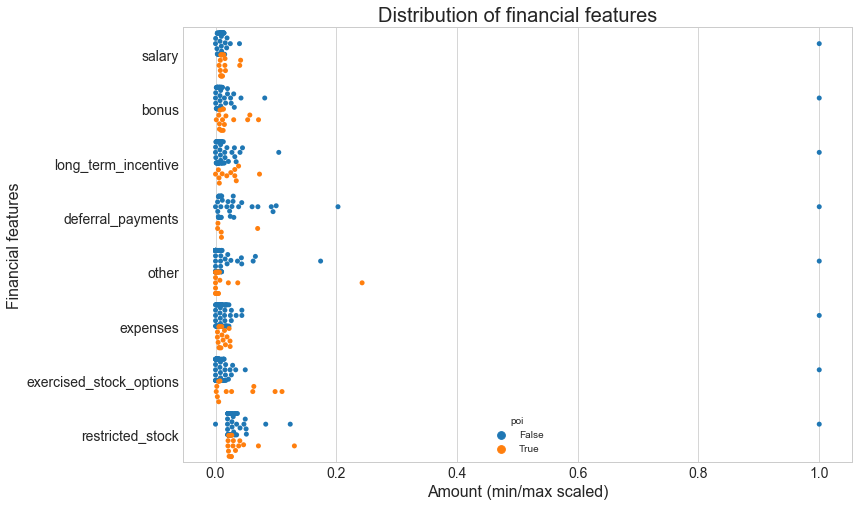

In [13]:
%matplotlib inline
from explore_datasets import plot_distribution
plot_distribution(financial_records)

From the plot above, we see that each feature has an outlier. We can have a closer look to this outlier:

In [14]:
financial_records[financial_records["value"] >= 0.9]

,name,poi,variable,value
104,TOTAL,False,salary,1.0
250,TOTAL,False,bonus,1.0
396,TOTAL,False,long_term_incentive,1.0
542,TOTAL,False,deferral_payments,1.0
688,TOTAL,False,other,1.0
834,TOTAL,False,expenses,1.0
980,TOTAL,False,exercised_stock_options,1.0
1126,TOTAL,False,restricted_stock,1.0


There is a TOTAL row in the dataset, we should get rid of it and re-plot the distribution:

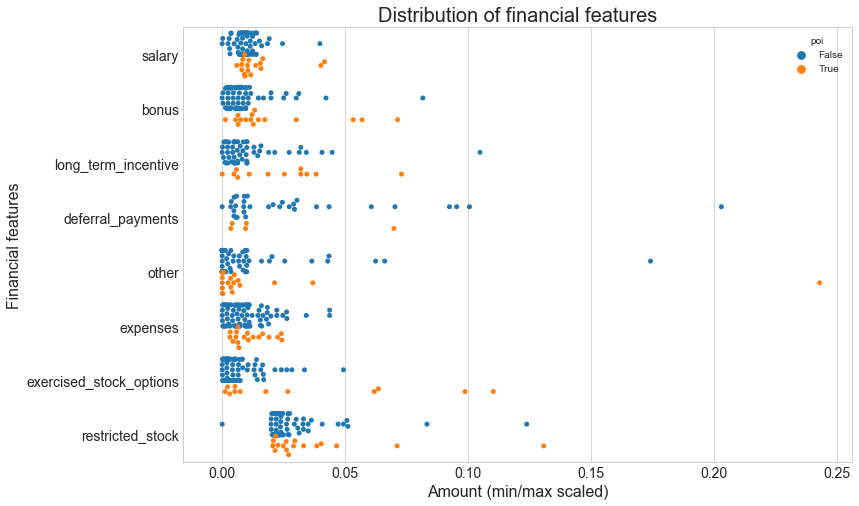

In [15]:
financial_records = financial_records[financial_records['name'] != "TOTAL"]
financial_data = financial_data[financial_data['name'] != "TOTAL"]
plot_distribution(financial_records)

From the above plot, there is no evident criteria to identify person of interest looking each feature independently. Apart from *exercised_stock_options* feature for which 4 highest values are for persons of interest, the other features show comparable distributions.

We can now have a look to non-financial data in this dataset. And we are particularly interested by emails data. The loaded dataset contains features related to emails:

In [16]:
#We only keep email data and POI
email_data = df.loc[:, ["email_address", "from_messages", "from_poi_to_this_person", "from_this_person_to_poi", "to_messages", 
                 "poi"]]
email_data.reset_index(inplace=True)
email_data.rename(columns={'names': 'name'}, inplace=True)
email_data = email_data[email_data['name'] != "TOTAL"]
email_data = email_data.applymap(convert_to_numeric)

This information is provided here as a "shortcut", but may be regenerated from e-mails dataset. As we have done with financial data, we are going to scale *from_poi_to_this_person* and *from_this_person_to_poi*. This time we are going to use the provided *from_messages* and *to_messages* to do so:

In [17]:
email_data = email_data.assign(**{'from_poi': email_data['from_poi_to_this_person']/email_data['to_messages'],
                                  'to_poi': email_data['from_this_person_to_poi']/email_data['from_messages']})

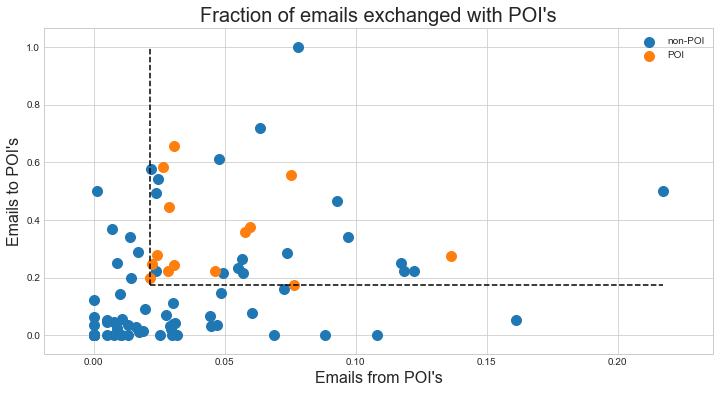

In [18]:
from explore_datasets import plot_email_data
plot_email_data(email_data)

We can see from the plot above that is quite easy to identify a quadrant (delimited with dashed lines) of space out of which people are not persons of interest. This is certainly a trait that machine learning algorithms will be able to identify. These two features are then valuable to use in input dataset for our machine learning algorithm.

<a id='Dataset questions'/>

### Dataset questions [*dataset*](#Dataset)

In [19]:
financial_data.shape[0]

145

Total number of data points: 145

This is after the removal of one outlier in the dataset which is an item holding the total values for each feature.

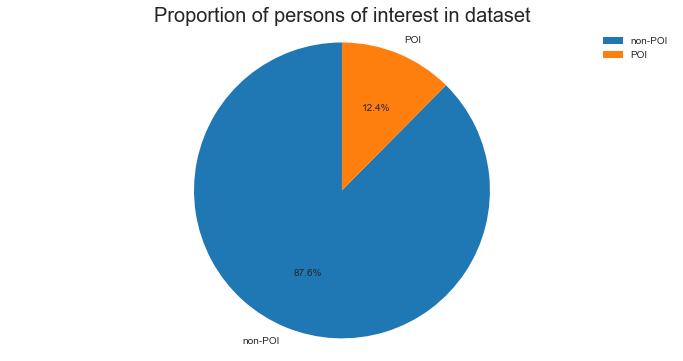

In [20]:
from explore_datasets import plot_classes
grouped = plot_classes(financial_data)

In [21]:
grouped.head()

,name,salary,bonus,long_term_incentive,deferral_payments,other,expenses,exercised_stock_options,restricted_stock
poi,,,,,,,,,
False,127,77,65,53,33,74,76,89,92
True,18,17,16,12,5,18,18,12,17


There are 145 people in dataset. 18 are persons of interest, 127 are not. In this financial data, we can see that we have missing values for each of the selected features (the count of feature differs from the one of *name*). *restricted_stock* is the most complete feature while *deferral_payments* is the one with less information.

In [22]:
grouped = email_data.groupby("poi", as_index=True).count()
grouped.head()

,name,email_address,from_messages,from_poi_to_this_person,from_this_person_to_poi,to_messages,from_poi,to_poi
poi,,,,,,,,
False,127,93,72,72,72,72,72,72
True,18,18,14,14,14,14,14,14


There are only 14 out of 18 POI's for whom we have an actual value for *from_poi* and *to_poi*. And only 72 non-POI's for which we have actual values for the same features out of 127.

We then have a list of ten features we will user later on in the analysis:
- salary
- bonus
- long_term_incentive
- deferral_payments
- other
- expanses
- exercised_stock_options
- restricted_stock
- from_poi
- to_poi

<a id="Feature"/>

## Feature selection [*top*](#Top)

In the [previous](#Dataset), we have explored the financial and email data that we have. We already have introduced new features for email based on recombination of features so that we have fractions of emails from and to POI's instead.

Additionaly, for financial data, we have scaled the features. This may not be required by some machine learning algorithms but will significantly improve the performance of some others. As email features are represented with email fractions, they are also already scaled.

In this section, we will then focus on feature selection algorithms. We wil identify various sets of features and then compare the performance of machine learning algorithms on those various sets.

<a id="Combine"/>

### Combine email and financial features [*feature selection*](#Feature)

So far, email and financial data are in different data frames. We are now going to combine both.

In [23]:
email_data_condensed = email_data[["name", "from_poi", "to_poi", "from_poi_to_this_person", "from_this_person_to_poi"]]
dataset = financial_data.merge(email_data_condensed, left_on="name", right_on="name")

The uncombined email data *from_poi_to_this_person* and *from_this_person_to_poi* are kept to assess they relative relevance with the new introduced features *from_poi* and *to_poi*.

In [24]:
features = [column for column in dataset.columns if column not in ["name", "poi"]]
print features

['salary', 'bonus', 'long_term_incentive', 'deferral_payments', 'other', 'expenses', 'exercised_stock_options', 'restricted_stock', 'from_poi', 'to_poi', 'from_poi_to_this_person', 'from_this_person_to_poi']


A last problem we have with this dataset is that some information is missing (NaN values). This will break scikit-learn algorithms. We have two options:

- remove any person in the dataset for which at least one feature is missing
- replace NaN values with actual values

In [25]:
dataset.dropna(axis=0, how='any').shape

(6, 14)

The first option leads to a dataset for which we only have 6 persons remaining. We have lost a lot of information. We might consider using the second option.

In order to minimize the impact of adding data in the dataset, NaN values are going to be replaced by the median value for each feature in the relevant class (POI/non-POI). For example, the missing bonus feature will be replaced by the median value of bonuses for non-POI's person if person is not a POI and by the median value of bonuses for POI persons if person is a POI.

In [26]:
from explore_datasets import FillNaNWithMedianValues  
dataset_cleaned = dataset.apply(FillNaNWithMedianValues(dataset.loc[:, "poi"], features))

We still have two unscalled features: *from_poi_to_this_person* and *from_this_person_to_poi*. Other financial features had been scaled while outlier was present, so this stage of scalling also modifies the financial features:

In [27]:
dataset_cleaned = dataset_cleaned.apply(scale)

<a id="Univariate"/>

### Univariate feature selection [*feature_selection*](#Feature)

In a univariate feature selection algorithm, each feature is evaluated independently. The following algorithms identifies the best 5 features. It also makes available the score of each feature:

In [28]:
from sklearn.feature_selection import SelectKBest

selection = SelectKBest(k=5)
selection.fit(dataset_cleaned[features], dataset_cleaned["poi"])
for feature, score in zip(features, selection.scores_):
    print "{:30s}{:.2f}".format(feature, score)

salary                        11.83
bonus                         18.90
long_term_incentive           23.24
deferral_payments             0.56
other                         4.16
expenses                      1.21
exercised_stock_options       40.15
restricted_stock              9.06
from_poi                      2.81
to_poi                        29.93
from_poi_to_this_person       6.97
from_this_person_to_poi       2.66


<a id="Recursive"/>

### Recursive feature selection [*feature selection*](#Feature)

In a recursive feature selection, a supervised classifier is trained with various combinations of features. The following algorithm identifies the best features, this way, we can have access to a full ranking of features. We use a support vector machine classifier with a linear kernel as it is the only one kernel exposing the feature importance, which is required by recursive feature selection algorithm:

In [29]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

selection = RFE(estimator=SVC(kernel="linear"), n_features_to_select=1)
selection.fit(dataset_cleaned[features], dataset_cleaned["poi"])
for feature, ranking in zip(features, selection.ranking_):
    print "{:30s}{:2d}".format(feature, ranking)

salary                         5
bonus                          7
long_term_incentive            2
deferral_payments              3
other                          6
expenses                      10
exercised_stock_options        1
restricted_stock              11
from_poi                      12
to_poi                         4
from_poi_to_this_person        9
from_this_person_to_poi        8


The two different algorithms ranked *exercised_stock_options* as the best feature. In [Data Exploration](#Exploration) section, we have seen that this feature would probably be useful as the four highest values are all POI's.

In both cases, *long_term_incentives*, *to_poi* and *salary* are considered as good features even if ranking differs.

The case of *deferral_payments* feature is different. It is poorly scored with univariate selection technique and highly ranked with recursive method.

During dataset exploration we have created two features: *from_poi* and *to_poi* which are respectively derived from *from_poi_to_this_person* and *from_this_person_to_poi*. It's interesting to see that *to_poi* is in both case considered as a better feature. However, this is the opposite for *from_poi* which is ranked lower than its *from_poi_to_this_person* counterpart.

Let's try again with a different estimate:

In [30]:
from sklearn.tree import DecisionTreeClassifier

selection = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=1)
selection.fit(dataset_cleaned[features], dataset_cleaned["poi"])
for feature, ranking in zip(features, selection.ranking_):
    print "{:30s}{:2d}".format(feature, ranking)

salary                        12
bonus                          3
long_term_incentive           11
deferral_payments              2
other                         10
expenses                       9
exercised_stock_options        8
restricted_stock               7
from_poi                       4
to_poi                         6
from_poi_to_this_person        1
from_this_person_to_poi        5


This leads to very different results:

- *bonus* still seems to be considered as an important feature
- *exercised_stock_options* is far lower in the list
- *deferral_payments* is ranked high, just like with other estimate (linear support vector classifier)
- email features are all ranked quite high
- newly introduced email features are both ranked below their counterparts.

<a id="Feature selection conclusion"/>

### Conclusion [*feature selection*](#Feature)

We have seen different ways to select features but also very different results. It seems now impossible to state which one is better. We have to wait for a full cross-validation process.

The machine learning step will then include different features selection algorithms with different number of selected features. This will slow down the machine learning step but will give better assessment of performance of those selection algorithms.

The choice of using features like *to_poi* and *from_poi* is debatable because part of the target (POI / non-POI) is actually contained in the feature. This might create a data leakage and cause the predicition model to have less accuracte predictions on unseen data.

<a id='Machine learning'/>

## Machine learning [*top*](#Top)

Now we have explored the dataset, cleaned it by removing outliers and replacing missing values, created new features and selected the most valuable features we are almost ready to start training a classifier algorithm.

Actually, we still need a final step before we can go. To be able to validate the performance of the classifier we need to split the dataset between a training set and a testing set. Without doing this, analyzing the performance of the classifier would be biassed as we would assess the performance on the dataset used to train the algorithm. The problem with that is that we cannot predict the behavior of the algorithms on unseen data. Said differently we cannot assess the bias-variance trade-off that we made. See [Appendix](#Appendix) for documents related to bias-variance trade-off.

<a id='Cross-validation strategy'>

### Cross-validation strategy [*machine learning*](#Machine learning)

We have two issues with the dataset:

- it is quite small (only 146 samples)
- the classes (POI and non-POI) are not evenly distributed: we have a very low percentage of POI's (12%)

We could have split once and for all dataset into a training and testing dataset, but we cannot rely on pure randomness to do that, as we cannot be sure to have enough POI's in the testing sample.

Moreover, moving POI's samples to the test dataset reduces even more the number of POI's we have in the training dataset.

I have then chosen to use technique that is going to split dataset multiple times with different samples each time. These methods implies that machine learning will run slower as the learning process is done multiple times. But as the dataset is quite small, this should not be a showstopper.

Moreover, Scikit-learn provides stratified versions of algorithms which enables to preserve the percentage of classes in train and test splits. This will increase the chance that F1, recall and precision scores may be calculated at each iteration of cross-validation.

In the next sections, the following strategies will be used:

- 3-fold: default number of splits when used in conjuction with grid search, 66% of dataset is used for training
- 8-fold: to maximize the size of training dataset, 87.5% will be used at each iteration of cross-valudation

<a id='Algorithm choice'/>

### Algorithm choice [*machine learning*](#Machine learning)

Scikit-learn offers a myriad of algorithms. The problem we have calls for supervised classification algorithms because we already know the classes that we want to predict (POI / non-POI).

The following algorithms will be used and their performance will be compared.

- a multilayer perceptron (artifical neural network)
- a support vector machine with radial-basis function kernel
- ensemble method (AdaBoost) using a decision tree classifier

As already discussed, we will also use three different feature selection algorithms:

- a univariate method with SelectKBest
- a recursive method with RFE (recursive feature elimination) using a simple linear-kernel support vector classifier
- and a recursive method with a decision tree classifier as estimator

Finally, we will also have two different cross-validation techniques:

- stratified 3-fold 
- stratified 8-fold

Overall, this are 18 different combinations that are going to be compared in terms of performance (fit time, f1, recall and precision).

To streamline the overall execution, we will use a [pipeline](http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html). And we will also use a [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to help us fine tuning the classification algorithms.

<a id='Bias variance trade-off'/>

### Bias variance trade-off [*machine learning*](#Machine learning)

Now we have selected our family of classification algorithms, we need to find the right combination of parameters for each of them.

Scikit-Learn provides default values for each parameter in classification algorithm. This is for the sake of uniformisation in the way algorithms may be used and parameteres with model selection techniques (like the grid search technique we use in this project). But more often than not, default parameters are not suitable for the problem we try to solve.

Tuning the classification algorithms parameters enables to find a right balance between the bias and variance of the prediction model. The ideal situation is to have a low bias and low variance model. The more assumptions are made about the training dataset, the more bias we have. For example, if we try to predict a non-linear separable behavior with a linear classifier, we have a high bias because we made the assumption that data is linearly separable while it is not. This kind of model will have a very low score on the training dataset: it will not be able to even predict the data used for training the model. On the other side, we have a high variance model when the model tries to predict perfectly the training data and cannot generalize to unseen data. This situation is called overfitting. One typical example would be to have a noisy linear training dataset and a predicition model bieng able to predict the noise with the training data.

One way to control the bias for example for support vector machine is to set the kernel. A linear problem calls for a linear kernel, quasi-linear might use a polynomial kernel, but highly non-linear problem would require a radial basis function kernel. The equivalent for a multilayer perceptron would be to select the right activation function.

The variance may be controled, for example, by tuning the parameter controlling the penalty term of algorithm. This penalty parameter is used by the classifier to evaluate the cost of misprediction in the training dataset. A high value forces the algorithms to further improve the separations (hyperplanes in the case of support vector machines, deeper tests for decision trees...) it creates internaly to best fit the training data.

Bias and variance of classification are unfornutatly not independent. For example, decreasing the penalty term of a support vector classifier decreases the variance while increasing the bias (we make more and more assumptions).

Parameters tuning enable to find a trade-off between low bias and low variance.

<a id='Learn'/>

### Time to learn ! [*machine learning*](#Machine learning)

It's now time to setup the pipelines.

Let's start by configuring the feature selection algorithms. *k* and *n_features_to_select* will be configured with the grid search technique. When using 12 features, all features are used for training, there is no selection anymore.

In [31]:
select_kbest = SelectKBest()
select_rfe_svc = RFE(estimator=SVC(kernel="linear"))
select_rfe_tree = RFE(estimator=DecisionTreeClassifier())

select_algorithms = [
    ('K-best', select_kbest, {'select__k': [2, 5, 8, 12]}),
    ('RFE-SVC', select_rfe_svc, {'select__n_features_to_select': [2, 5, 8, 12]}),
    ('RFE-tree', select_rfe_tree, {'select__n_features_to_select': [2, 5, 8, 12]}),
]

The classification algorithms:

- SVC (support vector machine classifier) will use a radial-basis function kernel and the *C* and *gamma* parameters will be tuned.
- MLP (multi-layer perceptron) will use different combinations of hidden layer, different solvers for the back-propagation, different learning rates, different *alpha* values and different activation functions for the neurons.
- AdaBoost will use a decision tree classifier as base estimator. The maximum depth of base estimator and the number of estimators in the ensemble method will be investigated.

In [32]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

classify_svc = SVC()
classify_mlp = MLPClassifier()
classify_adt = AdaBoostClassifier(DecisionTreeClassifier())

classify_algorithms = [
    ('SVC', classify_svc, {'classify__C': [1., 10., 100., 1000., 10000., 10000.], 
                           'classify__gamma': [0.1, 0.01, 0.001, 0.0001, 0.00001]}),
    ('MLP', classify_mlp, {'classify__learning_rate_init': [0.01, 0.001, 0.0001],
                           'classify__solver': ['lbfgs', 'adam'],
                           'classify__hidden_layer_sizes': [(10,), (20,), (10, 10)],
                           'classify__alpha': [0.001, 0.0001, 0.00001],
                           'classify__activation': ['logistic', 'relu']}),
    ('AdaBoost-tree', classify_adt, {'classify__base_estimator__max_depth': [1, 2, 4, 8, 16], 
                                     'classify__n_estimators': [25, 50, 100]}),
]

The cross-validation algorithms:

In [33]:
from sklearn.model_selection import StratifiedKFold
validate_3fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
validate_8fold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1234)

validation_algorithms = [
    ('3-Fold', validate_3fold),
    ('8-Fold', validate_8fold),
]

We can now build the pipelines and apply the grid search method with cross-validation. We collect different scoring but will keep F1 as the more relevant (this choice is justified [later](#Compare algorithms)). *n_jobs* enables to take advantage of multicore machines and speed-up the learning process.

If you want to force the learning time, switch the below variable from False to True. By default, the learning results are recovered from a saved file.

> **Warning**: 
> The learning time may be long. You can increase or reduce the *N_JOBS* variable to use less or more cores on your  
> computer.

In [34]:
FORCE_LEARNING = True
GRID_RESULTS = 'dataset/grid_results.pkl'
N_JOBS = 6

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
import pickle
import os

if not os.path.exists(GRID_RESULTS) or FORCE_LEARNING:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grids = { }
        for select_algo in select_algorithms:
            for classify_algo in classify_algorithms:
                pipeline = Pipeline([('select', select_algo[1]), ('classify', classify_algo[1])])
                for validation_algo in validation_algorithms:
                    params = {}
                    params.update(select_algo[2])
                    params.update(classify_algo[2])
                    grid = GridSearchCV(pipeline, 
                                         params, 
                                         cv=validation_algo[1], 
                                         scoring=['accuracy', 'f1', 'precision', 'recall'],
                                         refit='f1',
                                         n_jobs=6)
                    grids[(select_algo[0], classify_algo[0], validation_algo[0])] = grid
                    print (select_algo[0], classify_algo[0], validation_algo[0]), 
                    grid.fit(dataset_cleaned[features], dataset_cleaned["poi"])
                    print "done"
        with open(GRID_RESULTS, 'w') as fobj:
            pickle.dump(grids, fobj)
else:
        with open(GRID_RESULTS, 'r') as fobj:
            grids = pickle.load(fobj)

('K-best', 'SVC', '3-Fold') done
('K-best', 'SVC', '8-Fold') done
('K-best', 'MLP', '3-Fold') done
('K-best', 'MLP', '8-Fold') done
('K-best', 'AdaBoost-tree', '3-Fold') done
('K-best', 'AdaBoost-tree', '8-Fold') done
('RFE-SVC', 'SVC', '3-Fold') done
('RFE-SVC', 'SVC', '8-Fold') done
('RFE-SVC', 'MLP', '3-Fold') done
('RFE-SVC', 'MLP', '8-Fold') done
('RFE-SVC', 'AdaBoost-tree', '3-Fold') done
('RFE-SVC', 'AdaBoost-tree', '8-Fold') done
('RFE-tree', 'SVC', '3-Fold') done
('RFE-tree', 'SVC', '8-Fold') done
('RFE-tree', 'MLP', '3-Fold') done
('RFE-tree', 'MLP', '8-Fold') done
('RFE-tree', 'AdaBoost-tree', '3-Fold') done
('RFE-tree', 'AdaBoost-tree', '8-Fold') done


We convert all results into a data frame:

In [36]:
results_dataset = pd.DataFrame()
for (key, value) in grids.iteritems():
    select_algo, classify_algo, validate_algo = key
    df = pd.DataFrame(grids[key].cv_results_)
    keep_columns = filter(lambda x: 'time' in x or 'test' in x or 'param' in x, df.columns)
    keep_columns = filter(lambda x: not (x.startswith('split')), keep_columns)
    df = df[keep_columns]
    df = df.assign(select=select_algo, classify=classify_algo, validate=validate_algo)
    if "param_select__n_features_to_select" in df.columns:
        df.rename(columns={"param_select__n_features_to_select": "param_select__n_features"}, inplace=True)
    elif "param_select__k" in df.columns:
        df.rename(columns={"param_select__k": "param_select__n_features"}, inplace=True)
    results_dataset = results_dataset.append(df)
results_dataset.reset_index(drop=True, inplace=True)
print results_dataset.columns

Index([u'classify', u'mean_fit_time', u'mean_score_time',
       u'mean_test_accuracy', u'mean_test_f1', u'mean_test_precision',
       u'mean_test_recall', u'param_classify__C',
       u'param_classify__activation', u'param_classify__alpha',
       u'param_classify__base_estimator__max_depth', u'param_classify__gamma',
       u'param_classify__hidden_layer_sizes',
       u'param_classify__learning_rate_init', u'param_classify__n_estimators',
       u'param_classify__solver', u'param_select__n_features', u'params',
       u'rank_test_accuracy', u'rank_test_f1', u'rank_test_precision',
       u'rank_test_recall', u'select', u'std_fit_time', u'std_score_time',
       u'std_test_accuracy', u'std_test_f1', u'std_test_precision',
       u'std_test_recall', u'validate'],
      dtype='object')


<a id='Compare algorithms'/>

### Compare algorithms [*machine learning*](#Machine learning)

Now we have trained multiple algorithms with different parameters, we might be interested in comparing the performance of the various algorithms. 

The following scores will be used in this section:

- accuracy
- recall
- precision
- F1 score

All comparisions are made using the scores obtained on the **test samples**, not the training ones.

This [blog post](http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) provides a clear description. The **accuracy** is the ratio of correctly predicted observations (positive or negative) over the total number of observations. In our case, as we have an unbalanced distribution of POI and non-POI's, having an algorithm returning always "non-POI" as prediction would have a high accuracy. That's why it's not relevant in our case. The **recall** is the capability to correctly predict positive observations from all actual positive obervations. In our case, it's the capability we have to identify persons of interest in a list of actual persons of interest. The **precision** is somehow the confidence we can have if person has been predicted as a person of interest.

Said differently, if you want to send people in jail with your algorithm because they are guilty of fraud in the Enron case, you want to make sure that precision is 1.0 ! Otherwise you will have to blame yourself for sentencing innocents. With a low recall score, you take the risk of having guilty people totally free.

The **F1 score** is an average of recall and precision. That's why it has been chosen as the main metric.

Let's start with a comparison of feature selection algorithms. The F1 scores are aggregated for all classifier methods and for all split made during cross-validation:

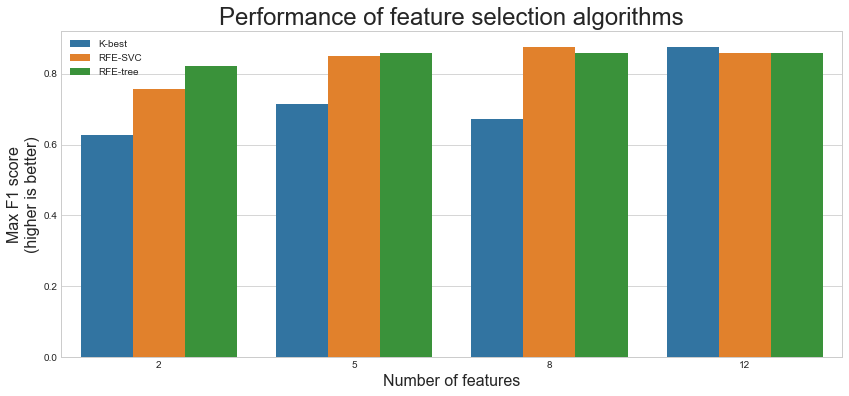

In [37]:
from explore_datasets import plot_select
compare_select = results_dataset.groupby(["select", "param_select__n_features"], 
                                         as_index=True)[["mean_test_f1", "mean_fit_time"]].describe()
compare_select.reset_index(drop=False, inplace=True)
plot_select(compare_select)

Even with a low number of features, RFE algorithm obtains good results. There is a significant improvement between 2 and 5 features. The F1 score even tends to decrease when number of features increases above 8. With a 12 features, each algorithm provides the same performance: the differences observed here are solely due to randomization process. SelectKBest is one of the simplest but is less powerfull than the RFE.

We can now compare classification algorithms. The box plots make appear: median, first and last quartiles in addition to 1.5 * interquartile range. Beyond that limit, outliers are represented with diamond shapes.

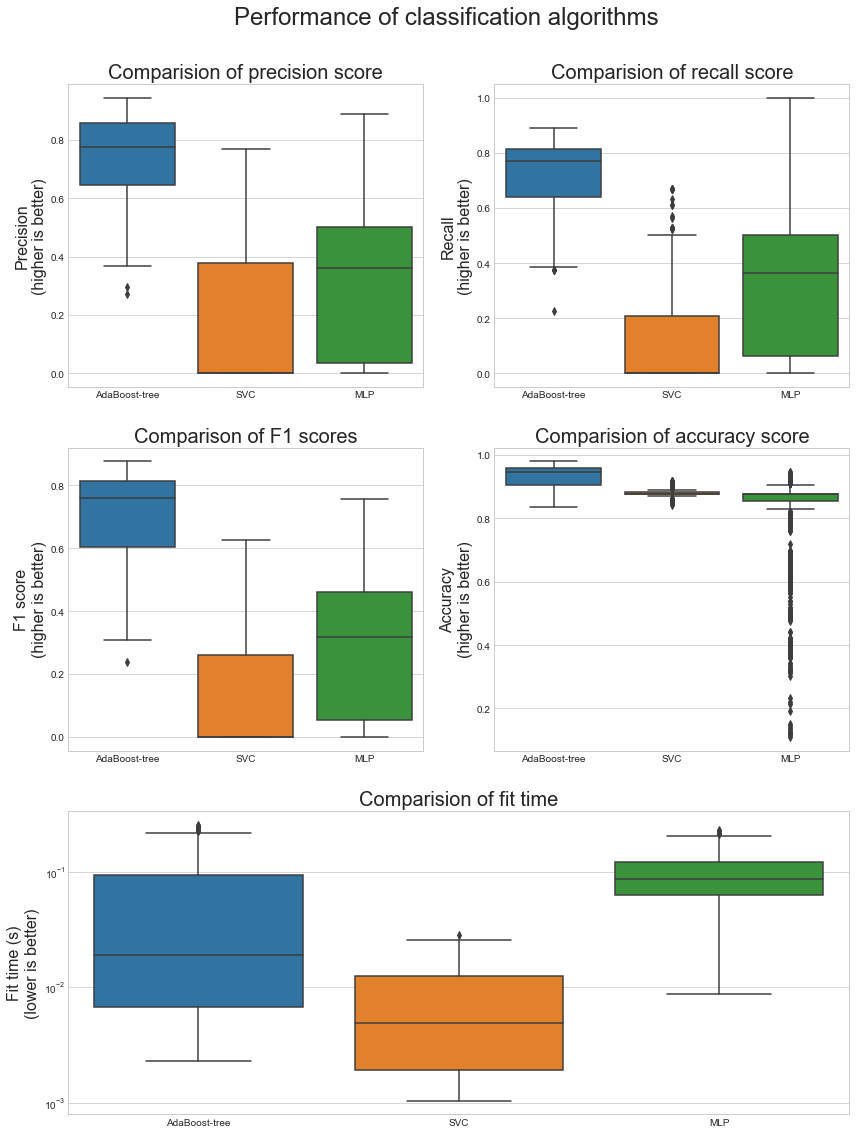

In [38]:
from explore_datasets import plot_classify
compare_classify = results_dataset[["classify", "mean_test_recall", "mean_test_precision", "mean_test_f1", 
                                    "mean_test_accuracy", "mean_fit_time"]]
plot_classify(compare_classify)

First, we can see that AdaBoost with a decision tree classifier outperforms the other algorithms. This does not mean it's a better algorithm. It just means that the parameters we have tuned with grid search technique have been able to adjust the model to obtain that level of precision and recall.

Then, it appears that we have a dissymmetry between precision and recall. AdaBoost-tree seems to have comparable scores but SVC has better precision than recall. In the contrary, MLP shows better results in terms of recall with some configuration reaching a score of 1.0. As already discussed, in our case we are more interested in precision than in recall.

SVC is ranked third on all scores. With an accuracy above 0.85, it only has very precision and recall below 0.8. This illustrates that accuracy score, at least in our example, cannot be trusted.

We can see that F1 score reflects both precision and recall, as expected.

Finally, in addition of having the best scores, AdaBoost-tree also has decent fit time. MLP classifier is an order of magnitude slower in average and SVC is the faster of the three.

It may also be interesting to compare the cross-validation algorithms.

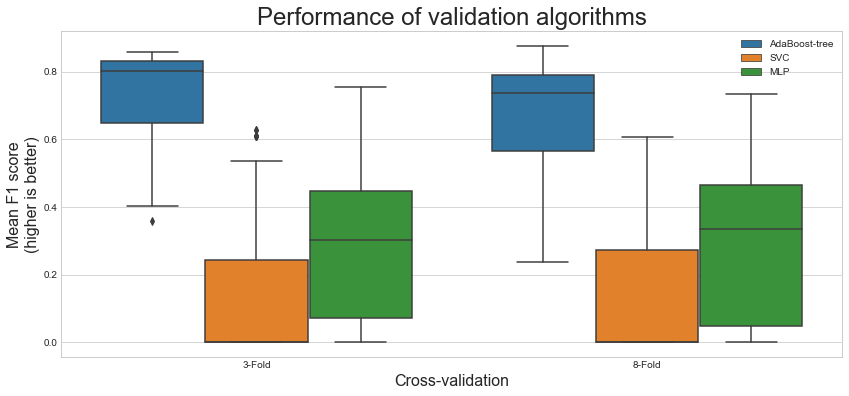

In [39]:
from explore_datasets import plot_validate
plot_validate(results_dataset)

Results are similar, there is no obvious bias in the results due to the cross-validation strategy choice. 8-Fold strategy seems to have better performances for AdaBoost-tree. This might be due to two factors:

- 8-Fold has smaller test samples. It is "easier" to perform well on a small series of questions than on a longer one.
- 8-Fold also has larger training samples, which means that algorithm may have access to additional valuable information to increase its fitness.

<a id='Learning conclusion'>

### Conclusion [*machine learning*](#Machine learning)

The best configuration for each familly is reported below:

In [40]:
#Best AdaBoost classifiers
best_classify = results_dataset[results_dataset["classify"] == 'AdaBoost-tree'].sort_values("mean_test_f1", ascending=False)
best_classify.nlargest(3, 'mean_test_f1')[["mean_test_f1", "mean_test_precision", "mean_test_recall", "param_classify__base_estimator__max_depth", "param_classify__n_estimators", "select", "param_select__n_features"]]

,mean_test_f1,mean_test_precision,mean_test_recall,param_classify__base_estimator__max_depth,param_classify__n_estimators,select,param_select__n_features
2351,0.875862,0.875862,0.875862,2,100,K-best,12
438,0.875862,0.875862,0.875862,2,50,RFE-SVC,8
2807,0.857401,0.905419,0.834483,16,100,K-best,12


The 3 best scores have been obtained with a *max_depth* of 2 for base estimator. 50 estimators seems to be enough with 8 features selected by RFE-SVC

In [41]:
#Best SVC classifiers
best_classify = results_dataset[results_dataset["classify"] == 'SVC'].sort_values("mean_test_f1", ascending=False)
best_classify.nlargest(3, 'mean_test_f1')[["mean_test_f1", "mean_test_precision", "mean_test_recall", "param_classify__C", "param_classify__gamma", "select", "param_select__n_features"]]

,mean_test_f1,mean_test_precision,mean_test_recall,param_classify__C,param_classify__gamma,select,param_select__n_features
262,0.627056,0.682430,0.611494,10000,0.1,RFE-tree,8
282,0.627056,0.682430,0.611494,10000,0.1,RFE-tree,8
2711,0.610246,0.583621,0.667816,10000,0.1,K-best,12


The best score is obtained with *C* = 10000.0 and *gamma* = 0.1. Both with the 8 features detected with RFE-tree.

In [42]:
#Best MLP classifiers
best_classify = results_dataset[results_dataset["classify"] == 'MLP'].sort_values("mean_test_f1", ascending=False)
best_classify.nlargest(3, 'mean_test_f1')[["mean_test_f1", "mean_test_precision", "mean_test_recall", "param_classify__hidden_layer_sizes", "param_classify__activation", "param_classify__learning_rate_init", "param_classify__solver", "param_classify__alpha", "select", "param_select__n_features"]]

,mean_test_f1,mean_test_precision,mean_test_recall,param_classify__hidden_layer_sizes,param_classify__activation,param_classify__learning_rate_init,param_classify__solver,param_classify__alpha,select,param_select__n_features
1032,0.755862,0.889655,0.666667,"(10,)",logistic,0.01,lbfgs,0.001,RFE-tree,2
1545,0.733103,0.733333,0.770115,"(10,)",logistic,0.001,lbfgs,0.0001,RFE-tree,5
1072,0.731285,0.822069,0.666667,"(20,)",logistic,0.0001,lbfgs,0.001,RFE-tree,2


Best scores are for *logistic* function activation combined with the *lbfgs* solver and default values for *learning rate* (0.001) and *alpha* (0.0001). In the contrary, the number of neurons in the hidden layer has been reduced to 10 (instead of 100). The major difference with AdaBoost-tree and SVC is that best score here is obtained when using the 2 or 5 features selected by RFE-tree algorithm.

<a id='Conclusion'/>

## Conclusion [*top*](#Top)

In this project, we have explored some capabilities offered by Scikit-Learn to create predictive models by testing and combining various algorithms for feature selection, classification and cross-validation.

We have configured three different classifiers matching the required criteria (score above 0.3 for both recall and precision):

| Classifier     | F1       | Precision | Recall   |
|----------------|----------|-----------|----------|
| AdaBoost-tree  | 0.876    | 0.876     | 0.876    |
| MLP            | 0.756    | 0.890     | 0.667    |
| SVC            | 0.627    | 0.682     | 0.611    |

This is not an absolute comparison of the algorithms as some of them appears to be more difficult to tune (MLP especially). Overall the simplicity (conceptually and in terms of configuration) of AdaBoost with decision tree classifier combined with decent fitting time makes it a top notch choice for this problem !

It actually takes some time to identify relevant parameters for grid search technique with support vector classifier and neural network while it was pretty simple with AdaBoost and decision tree. A first bad configuration of MLP (using default number of hidden layers) led to very low maximum F1 score (below 0.2 !).

Even if the score of AdaBoost-tree meets project expectation, I wouldn't rely solely on it to send people to jail for fraud as we still have a huge chance (13%) of being wrong :)

It also appears that feature selection may be a difficult task. In our case we were limited to 12 features which is not much and we have seen that many different combination of features may be selected with the various tested algorithms. Introducing new features may also be a complicated task, relying on prior knowledge on the problem.

I still have the feeling that both SVC and MLP might be improved. There are also numerous of other techniques which could be tried with Scikit-Learn package (different grid search techniques, different base estimators with AdaBoost, better feature selection or dimension reduction (principal component analysis).

<a id='Pro Tips'/>

## Pro tips [*top*](#Top)

**Note**: This section has been added after project submission and contains advices from reviewer.

There are several other options to deal with missing values like:
- Replacing the values with means or medians.
- Remove the features that have an exceeding number of missing values.
- More complex approaches rely on analysing the distribution of missing values: https://en.wikipedia.org/wiki/Missing_data, http://scikit-learn.org/stable/modules/preprocessing.html


We can leverage the power of recursive feature selection to automate the selection process and find a good indication of the number of relevant features, here is an example of how the code might look like:

```python
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
lr = LogisticRegression()

rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(labels, 50),
          scoring='precision')
rfecv.fit(features, labels)
print("Optimal number of features : %d" % rfecv.n_features_)
print rfecv.support_
features=features[:,rfecv.support_]
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
```

Xgboost is one of Kaggle’s top algorithms and should be given a try. In the recent years one algorithm emerged as favourite in the machine learning community, it is actually one of the most used in Kaggle: Xgboost.
Here is an informative discussion on why that is the case: https://www.quora.com/Why-is-xgboost-given-so-much-less-attention-than-deep-learning-despite-its-ubiquity-in-winning-Kaggle-solutions. The algorithm is not available Scikit Learn, here is how we can start working with it:http://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/


We could actually fully exploit pipelines and parameterize the whole process through cross validation. It means we can try out several algorithms automatically! Watch out though this is pretty advanced stuff, here is a great, informative, top notch tutorial from Zac Sewart: http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

<a id='Appendix'/>

## Appendix [*top*](#Top)

In [46]:
#Convert notebook to html
!jupyter nbconvert --to html --template html_minimal.tpl enron_fraud.ipynb

[NbConvertApp] Converting notebook enron_fraud.ipynb to html
[NbConvertApp] Writing 704845 bytes to enron_fraud.html


Illustrated documentation on pivoting, stacking and unstacking with pandas: http://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/.<hr>

Melt is the reverse of pivot operation, document is found  [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html).<hr>

Documentation on bias-variance trade-off on [Wikipedia](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) and 
[Machine Learning Mastery](https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/).<hr>

Creating [pipelines](http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html) with Scikit-Learn.<hr>

Finding the right parameters with a [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). This [page](http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
) also provides valuable information.<hr>

An explanation about the various [scores](http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) of machine learning algorithms. And the Scikit-Learn documentation on [scoring](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring).<hr>

Gaussian process classifier has also be analyzed rapidly. This [video](https://www.youtube.com/watch?v=Jv25sg-IYHU) helped me understanding the base concepts.<hr>

This post in [stats.stackexchange.com](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) helped me identifying my initial issues with multilayer perceptron.<hr>